In [1]:
import FC2_train_v2 as FC2_MPO_Net
from neural_networks import *

# Pre-processing

## 1. Train

In [2]:
D = 8

In [3]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
weights = FC2_MPO_Net.main(r_1=D, r_2=D)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy at step 0: 0.1835
Accuracy at step 1: 0.2788
Accuracy at step 2: 0.3516
Accuracy at step 3: 0.4377
Accuracy at step 7: 0.4792
Accuracy at step 8: 0.5171
Accuracy at step 12: 0.5877
Accuracy at step 13: 0.6716
Accuracy at step 20: 0.7387
Accu

## 2. Open weights matrices into correct MPO

In [23]:
sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

In [24]:
sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

## 3. Check that MPO is correct based on accuracy from model

In [26]:
FC2(MPO_0, bias_0, MPO_1, bias_1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


(95.13000000000001, 0.0049860477447509766)

In [28]:
temp = con.contract_horizontal(MPO_0[0], MPO_0[1], 'right')
temp = con.contract_horizontal(temp, MPO_0[2], 'right')
W_0 = con.contract_horizontal(temp, MPO_0[3], 'right')

temp = con.contract_horizontal(MPO_1[0], MPO_1[1], 'right')
temp = con.contract_horizontal(temp, MPO_1[2], 'right')
W_1 = con.contract_horizontal(temp, MPO_1[3], 'right')

In [32]:
def compress_layer_stop(raw_state, phys_dim, threshold, compressed_state=0, plot=0, starting_point=1, stopping_point=9):
    """ Initializes a compressed state then sweeps left->right
        and right->left until a minimum is reached
        i.e. the difference in our metrics between sweeps is less than a
        specified threshold up to the bond dimension of the raw state

        Note: Does NOT normalize the state unlike the compression function
              found in compression.py

    Args:
        raw_state: MPS to be compressed
        phys_dim: List of physical dimensions by site
        threshold: Difference between sweeps under which a solution is found
        compressed_state: Initial starting state if necessary
                          otherwise a random MPS is ini
        plot: Whether or not to plot the compression values (0 off, 1 on)

    Returns:
        compressions: Final compressed state at each bond dimension
        best_dist: List of overlap values for each bond dimension
        best_sim: List of cosine similarity values for each bond dimension
    """
    if compressed_state == 0:
        compressed_state = init.initialize_random_MPS_with_changing_phys_dim(phys_dim,
                                                                             num_sites=len(raw_state),
                                                                             bond_dim=starting_point)
    bond_dim_raw_state = raw_state[math.ceil(len(raw_state)/2)].shape[0]
    max_bond_dim = starting_point

    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(metrics.overlap(compressed_state, raw_state))
    sim.append(metrics.similarity(compressed_state, raw_state))
    best_dist = []
    best_sim = []
    compressions = []
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            compressed_state[site], compressed_state[site+1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='right')
        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            compressed_state[site], compressed_state[site-1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='left')

        # Metrics taken after each sweep
        dist.append(metrics.overlap(compressed_state, raw_state))
        sim.append(metrics.similarity(compressed_state, raw_state))
        # Check if sweeps are still working
        if np.abs(dist[-2]-dist[-1]) < threshold:
            # Normalize to maintain length and update metrics
            #compressed_state, _ = can.left_normalize(compressed_state)
            best_dist.append(dist[-1])
            best_sim.append(sim[-1])
            print("Sim:", best_sim[-1], "Dist:", best_dist[-1], "BondDim:", max_bond_dim)
            compressions.append(compressed_state[:])

            # Break if we cannot increase bond dimension anymore
            if max_bond_dim+1 == bond_dim_raw_state or max_bond_dim+1 == stopping_point:
                break

            # Break if changing bond dimension did not do enough
            #if len(best_dist) > 1 and np.abs(best_dist[-2]-best_dist[-1] < threshold):
            #    break

            # Update each tensor by increasing bond dimension
            for i, tensor in enumerate(compressed_state):
                if tensor.ndim == 2:
                    new_tensor = np.zeros((tensor.shape[0], tensor.shape[1]+1))
                    new_tensor[:tensor.shape[0], :tensor.shape[1]] = tensor
                    compressed_state[i] = new_tensor

                elif tensor.ndim == 3:
                    new_tensor = np.zeros((tensor.shape[0]+1, tensor.shape[1]+1, tensor.shape[2]))
                    new_tensor[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] = tensor
                    compressed_state[i] = new_tensor
            max_bond_dim = compressed_state[math.ceil(len(compressed_state)/2)].shape[0]

    if plot == 1:
        max_bond_dim = range(1, len(best_dist)+1)
        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('Compressed Dimension')
        ax1.set_ylabel('Cosine Similarity', color=color)
        ax1.plot(max_bond_dim, best_sim, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Euclidean Distance', color=color)
        ax2.plot(max_bond_dim, best_dist, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title('Metrics vs. Compressed Dimension')

        fig.tight_layout()
        plt.show()

        plt.figure()
        plt.title("Cosine Similarity vs. Euclidean Distance")
        plt.xlabel("Euclidean Distance")
        plt.ylabel("Cosine Similarity")

        plt.plot(best_dist, best_sim)

    return compressions, best_dist, best_sim

In [60]:
vector_W0 = np.reshape(W_0, (W_0.shape[0]*W_0.shape[1]))
MPS_0 = vector_to_left_canonical_MPS_NN(vector_W0, phys_dim=[4, 4, 28, 28, 4, 4])

vector_W1 = np.reshape(W_1, (W_1.shape[0]*W_1.shape[1]))
MPS_1 = vector_to_left_canonical_MPS_NN(vector_W1, phys_dim=[2, 2, 8, 20, 2, 2])

Sim: 0.8464807365934519 Dist: 22.246656428620394 BondDim: 100
Sim: 0.8491031212777047 Dist: 22.0558315914486 BondDim: 101
Sim: 0.8517241114843542 Dist: 21.86344409349072 BondDim: 102
Sim: 0.8540366466839697 Dist: 21.69228116049625 BondDim: 103
Sim: 0.8564031686242254 Dist: 21.515712732765365 BondDim: 104
Sim: 0.8587061643949822 Dist: 21.342481622859875 BondDim: 105
Sim: 0.8608112715022773 Dist: 21.182896415604844 BondDim: 106
Sim: 0.8630143013693855 Dist: 21.0145900974608 BondDim: 107
Sim: 0.8650883802281286 Dist: 20.854894011352076 BondDim: 108
Sim: 0.8671738412087794 Dist: 20.693078986101295 BondDim: 109
Sim: 0.8691146161746865 Dist: 20.541345350711044 BondDim: 110
Sim: 0.8710150403493059 Dist: 20.391672372537496 BondDim: 111
Sim: 0.8730555169577877 Dist: 20.229736428737905 BondDim: 112
Sim: 0.8750237291977372 Dist: 20.07229769818053 BondDim: 113
Sim: 0.8768935979548921 Dist: 19.92157304122237 BondDim: 114
Sim: 0.8788459171323979 Dist: 19.76297566728733 BondDim: 115
Sim: 0.8807227647

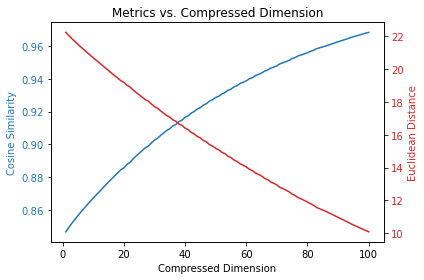

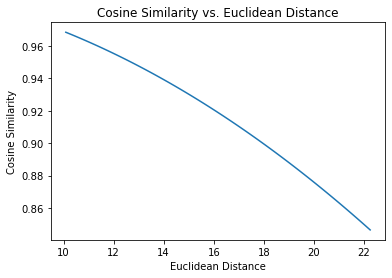

In [19]:
compressed_MPS_0, dist0, sim0 = compress_layer_stop(MPS_0, phys_dim=[4, 4, 28, 28, 4, 4], threshold=1e-1, plot=1, starting_point=100, stopping_point=200)

Sim: 0.05658965502994895 Dist: 5.8844368683766435 BondDim: 1
Sim: 0.20944958585485657 Dist: 5.386657665547291 BondDim: 2
Sim: 0.36210683634834523 Dist: 4.838698529602555 BondDim: 3
Sim: 0.5340372067845506 Dist: 4.135520811903485 BondDim: 4
Sim: 0.6021349306761283 Dist: 3.8213999770319056 BondDim: 5
Sim: 0.666394238036492 Dist:3.4992209213402394 BondDim: 6
Sim: 0.7117550452331005 Dist: 3.2526358767273 BondDim: 7
Sim: 0.7477246011212331 Dist: 3.042930557809956 BondDim: 8
Sim: 0.7797312615297699 Dist: 2.843354588655546 BondDim: 9
Sim: 0.8108242822400143 Dist: 2.6350404475169187 BondDim: 10
Sim: 0.8365936131201508 Dist: 2.4490018004263474 BondDim: 11
Sim: 0.8605280966964554 Dist: 2.2625487969981823 BondDim: 12
Sim: 0.8829124994485531 Dist: 2.0730503885664135 BondDim: 13
Sim: 0.9006291594301203 Dist: 1.9097832170869522 BondDim: 14
Sim: 0.915850984417519 Dist: 1.7574343498297353 BondDim: 15
Sim: 0.9305850948718735 Dist: 1.5961766669614583 BondDim: 16
Sim: 0.9422347205210846 Dist: 1.456089366

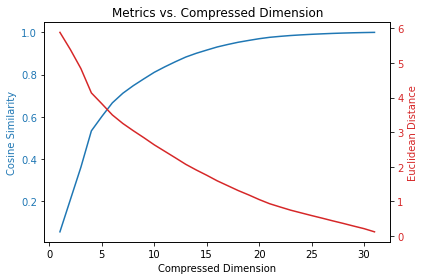

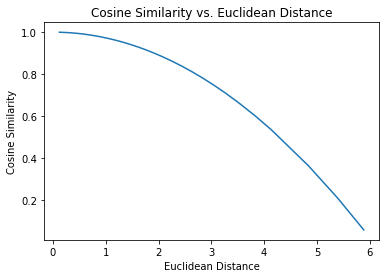

In [20]:
compressed_MPS_1, dist1, sim1 = compress_layer(MPS_1, phys_dim=[2, 2, 8, 20, 2, 2], threshold=1e-8, plot=1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 0
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 1
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 2
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 3
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


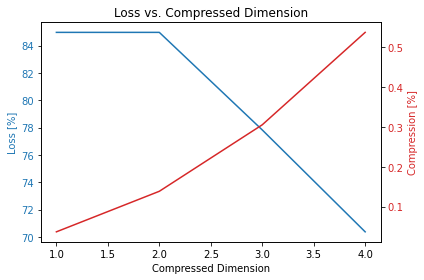

Text(0, 0.5, 'Loss [%]')

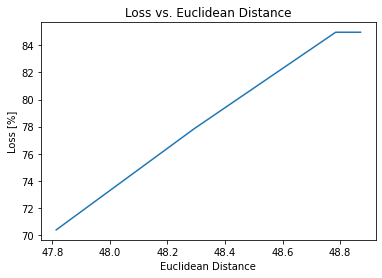

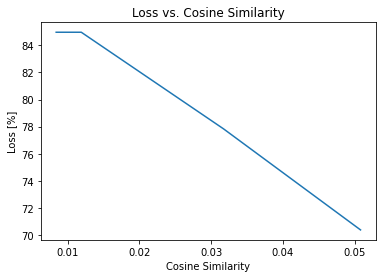

In [37]:
### Accuracy when compressing W_0
acc_orig, time_orig = FC2(MPS_0, bias_0, MPS_1, bias_1)

acc_compressed = []
time_compressed = []
params = []
for i in range(0, len(compressed_MPS_0)):
    print("dim:", i)
    MPS_0_test = compressed_MPS_0[i]
    MPS_1_test = MPS_1

    acc, t = FC2(MPS_0_test, bias_0, MPS_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

    total_params = 0
    for tensor in MPS_0_test:
        total_params += tensor.size
    params.append(total_params)

params_orig = 784*256
x = range(1, len(compressed_MPS_0)+1)
params = np.array(params)/params_orig*100
loss = [acc_orig-x for x in acc_compressed]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Compressed Dimension')
ax1.set_ylabel('Loss [%]', color=color)
ax1.plot(x, loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(x, params, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Loss vs. Compressed Dimension')
fig.tight_layout()
plt.show()

plt.figure()
plt.plot(dist0, loss)
plt.title('Loss vs. Euclidean Distance')
plt.xlabel('Euclidean Distance')
plt.ylabel('Loss [%]')

plt.figure()
plt.plot(sim0, loss)
plt.title('Loss vs. Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Loss [%]')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 0
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 1
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 2
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 3
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 4
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels

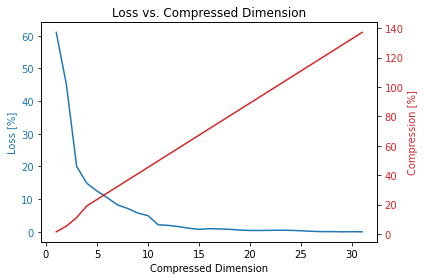

Text(0, 0.5, 'Loss [%]')

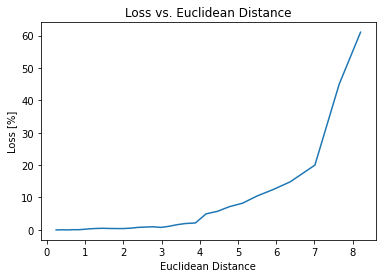

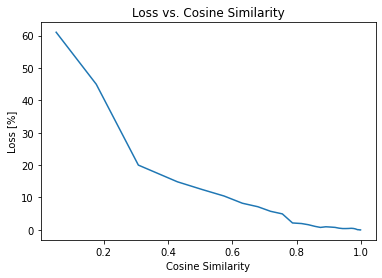

In [38]:
### Accuracy when compressing W_1
acc_orig, time_orig = FC2(MPS_0, bias_0, MPS_1, bias_1)

acc_compressed = []
time_compressed = []
params = []
for i in range(0, len(compressed_MPS_1)):
    print("dim:", i)

    MPS_0_test = MPS_0
    MPS_1_test = compressed_MPS_1[i]

    acc, t = FC2(MPS_0_test, bias_0, MPS_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)

    total_params = 0
    for tensor in MPS_1_test:
        total_params += tensor.size
    params.append(total_params)

params_orig = 256*10
x = range(1, len(compressed_MPS_1)+1)
params = np.array(params)/params_orig*100
loss = [acc_orig-x for x in acc_compressed]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Compressed Dimension')
ax1.set_ylabel('Loss [%]', color=color)
ax1.plot(x, loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
ax2.plot(x, params, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Loss vs. Compressed Dimension')
fig.tight_layout()
plt.show()

plt.figure()
plt.plot(dist1, loss)
plt.title('Loss vs. Euclidean Distance')
plt.xlabel('Euclidean Distance')
plt.ylabel('Loss [%]')

plt.figure()
plt.plot(sim1, loss)
plt.title('Loss vs. Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Loss [%]')

In [58]:
### Check changes in W0 for constant W1
acc_compressed = []
time_compressed = []
W1_dim = len(compressed_MPS_1)
MPS_1_test = MPS_1
params0 = []
for W0_dim in range(1, len(compressed_MPS_0)+1):
    print("dim:", W0_dim)
    MPS_0_test = compressed_MPS_0[W0_dim-1]

    acc, t = FC2(MPS_0_test, bias_0, MPS_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)
    total_params = 0
    for tensor in MPS_0_test:
        total_params += tensor.size
    params0.append(total_params)

params_orig = 784*256
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
loss0 = [acc_orig-x for x in acc_compressed]
params0 = np.array(params0)/params_orig*100

acc_compressed = []
time_compressed = []
W0_dim = len(compressed_MPS_0)
MPS_0_test = MPS_0
params1 = []
for W1_dim in range(1, len(compressed_MPS_1)+1):
    print("dim:", W1_dim)
    MPS_1_test = compressed_MPS_1[W1_dim-1]

    acc, t = FC2(MPS_0_test, bias_0, MPS_1_test, bias_1)
    acc_compressed.append(acc)
    time_compressed.append(t)
    total_params = 0
    for tensor in MPS_1_test:
        total_params += tensor.size
    params1.append(total_params)

params_orig = 256*10
acc_orig, time_orig = FC2(MPS_0, bias_0, MPS_1, bias_1)
loss1 = [acc_orig-x for x in acc_compressed]
params1 = np.array(params1)/params_orig*100


dim: 1
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 2
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 3
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 4
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
dim: 1
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels

Text(0, 0.5, 'Loss [%]')

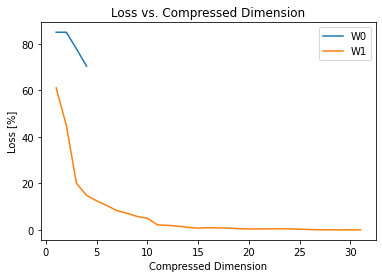

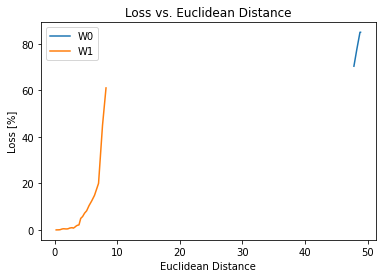

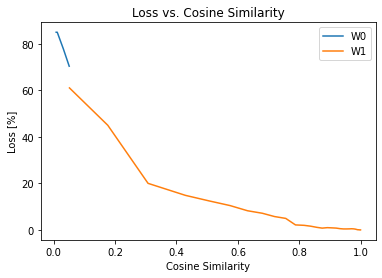

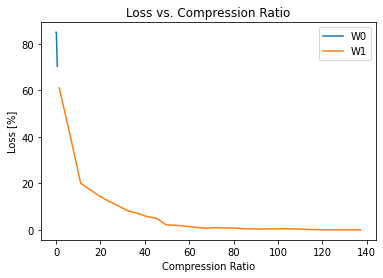

In [59]:
plt.figure()

plt.plot(range(1, len(compressed_MPS_0)+1), loss0, label="W0")
plt.plot(range(1, len(compressed_MPS_1)+1), loss1, label="W1")

plt.legend()
plt.title('Loss vs. Compressed Dimension')
plt.xlabel('Compressed Dimension')
plt.ylabel('Loss [%]')

plt.figure()
plt.plot(dist0, loss0, label="W0")
plt.plot(dist1, loss1, label="W1")
plt.legend()
plt.title('Loss vs. Euclidean Distance')
plt.xlabel('Euclidean Distance')
plt.ylabel('Loss [%]')

plt.figure()
plt.plot(sim0, loss0, label="W0")
plt.plot(sim1, loss1, label="W1")
plt.legend()
plt.title('Loss vs. Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Loss [%]')

plt.figure()
plt.plot(params0, loss0, label="W0")
plt.plot(params1, loss1, label="W1")
plt.legend()
plt.title('Loss vs. Compression Ratio')
plt.xlabel('Compression Ratio')
plt.ylabel('Loss [%]')

In [40]:
acc, _ = FC2(compressed_MPS_0[0], bias_0, compressed_MPS_1[20], bias_1)
print(acc)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
94.6


In [78]:
### Optimized path
# 1. Starting state
# 2. Compress all layers down by 1
# 3. Calculate delta_params in all directions
# 4. Calculate delta_acc in all directions
# 5. Moved based on minimizing delta_acc/delta_params

vector_W0 = np.reshape(W_0, (W_0.shape[0]*W_0.shape[1]))
MPS_0 = vector_to_left_canonical_MPS_NN(vector_W0, phys_dim=[4, 4, 28, 28, 4, 4])

vector_W1 = np.reshape(W_1, (W_1.shape[0]*W_1.shape[1]))
MPS_1 = vector_to_left_canonical_MPS_NN(vector_W1, phys_dim=[2, 2, 8, 20, 2, 2])

acc_orig, _ = FC2(MPS_0, bias_0, MPS_1, bias_1)
layers = [compressed_MPS_0[-1], compressed_MPS_1[-1]]

threshold = 0
last_updated = np.ones(len(layers))
loss = 0
while True:
    print(loss)
    # 1. Starting state
    MPS_0 = layers[0]
    MPS_1 = layers[1]

    # 2. Compress all layers down by 1
    dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
    dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]
    print(dim0, dim1)
    if last_updated[0] == 1:
        compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[4, 4, 28, 28, 4, 4], threshold=1e-1, compressed_dim=dim0-1)
    if last_updated[1] == 1:
        compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[2, 2, 8, 20, 2, 2], threshold=1e-3, compressed_dim=dim1-1)
    MPSs = [compressed_0, compressed_1]

    # 3. Calculate delta_params
    delta_params0 = calculate_params(MPS_0) - calculate_params(compressed_0)
    delta_params1 = calculate_params(MPS_1) - calculate_params(compressed_1)
    new_params = [delta_params0, delta_params1]

    # 4. Calculate delta_acc
    new_acc0, _ = FC2(compressed_0, bias_0, layers[1], bias_1)
    new_acc1, _ = FC2(layers[0], bias_0, compressed_1, bias_1)
    new_loss = [acc_orig-new_acc0, acc_orig-new_acc1]

    delta_loss0 = loss - new_loss[0]
    delta_loss1 = loss - new_loss[1]

    # 5. Calculate slope
    slope = [new_loss[0]/new_params[0], new_loss[1]/new_params[1]]
    for i, loss in enumerate(new_loss):
        if loss > threshold:
            slope[i] = np.inf
    # 6. Find minimum slope
    index = np.argmin(slope)

    # 7. Update layers
    if new_loss[0] > threshold and new_loss[1] > threshold:
        break
    else:
        layers[index] = MPSs[index]
        loss = new_loss[index]
        #acc = new_acc[index]
        last_updated = np.zeros(len(layers))
        last_updated[index] = 1
        print(last_updated)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
0
199 31
Sim: 0.999327460667757 Dist: 1.4490157872952014 BondDim: 198
Sim: 0.9991466677504808 Dist: 0.17693924687435078 BondDim: 30
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
[0. 1.]
-0.029999999999986926
199 30
Sim: 0.9989599499152467 Dist: 0.19525710410629762 BondDim: 29
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting .

In [79]:
layers[0][2].shape

(16, 169, 28)

In [80]:
acc, _ = FC2(layers[0], bias_0, layers[1], bias_1)
print(acc)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
95.15


In [81]:
params = calculate_params(layers[0]) + calculate_params(layers[1])
orig_params = 784*256 + 256*10

In [82]:
params/orig_params * 100

76.10595088161209